# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

# Imports

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

Using TensorFlow backend.


# Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K. 

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Download the images/masks and unzip the files 

Note that we have two foulders. The first one is `images` which contains the raw images and annotation which contains the masks as a `binary` foulder image.

# Generators

In [0]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))


        #preprocess the mask 
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
            raw = np.stack((raw,)*3, axis=-1)

        else:
            raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)      
    

In [0]:
batch_size = 32

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [0]:
x, y= next(train_generator)

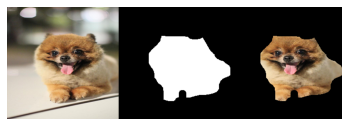

In [7]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [0]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# Model

In [0]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  # x = Input(batch_shape=(32, 256, 256, 3))
  inputs = x
  
  #Contracting layers
  nKernels = 8
  layers = []

  # level_1 (256, 256, 8)
  # level+layer
  layer11 = Conv2D(nKernels, 3, activation='relu', kernel_initializer='he_normal', padding='same') (x)
  layer11 = BatchNormalization()(layer11)
  layer12 = Conv2D(nKernels*2, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer11)
  layer12 = BatchNormalization()(layer12)
  layers.append(layer12)
  layer13 = MaxPooling2D() (layer12)
  
  # level_2 (128, 128, 16)
  layer21 = Conv2D(nKernels*2, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer13)
  layer21 = BatchNormalization()(layer21)
  layer22 = Conv2D(nKernels*4, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer21)
  layer22 = BatchNormalization()(layer22)
  layers.append(layer22)
  layer23 = MaxPooling2D() (layer22)

  # level_3 (64, 64, 32)
  layer31 = Conv2D(nKernels*4, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer23)
  layer31 = BatchNormalization()(layer31)
  layer32 = Conv2D(nKernels*8, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer31)
  layer32 = BatchNormalization()(layer32)
  layers.append(layer32)
  layer33 = MaxPooling2D() (layer32)

  # level_4 (32, 32, 64)
  layer41 = Conv2D(nKernels*8, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer33)
  layer41 = BatchNormalization()(layer41)
  layer42 = Conv2D(nKernels*16, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer41)
  layer42 = BatchNormalization()(layer42)
  layers.append(layer42)
  layer43 = MaxPooling2D() (layer42)

  # level_5 (16, 16, 128)
  layer51 = Conv2D(nKernels*16, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer43)
  layer51 = BatchNormalization()(layer51)
  layer52 = Conv2D(nKernels*32, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer51)
  layer52 = BatchNormalization()(layer52)
  layers.append(layer52)
  layer53 = MaxPooling2D() (layer52)

  # level_6 (8, 8, 256)
  layer61 = Conv2D(nKernels*32, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer53)
  layer61 = BatchNormalization()(layer61)
  layer62 = Conv2D(nKernels*64, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer61)
  layer62 = BatchNormalization()(layer62)
  layers.append(layer62)
  layer63 = MaxPooling2D() (layer62)
  
  # BottleNeck (4, 4, 512)
  bottleneck11 = Conv2D(nKernels*64, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer63)
  bottleneck11 = BatchNormalization()(bottleneck11)
  bottleneck12 = Conv2D(nKernels*64, 3, activation='relu', kernel_initializer='he_normal', padding='same') (bottleneck11)
  bottleneck12 = BatchNormalization()(bottleneck12)
  bottleneck13 = Conv2DTranspose(nKernels*32, 2, strides=(2, 2), kernel_initializer='he_normal', padding='same') (bottleneck12)
  # (8, 8, 256)
  level = len(layers) - 1
  layer71 = Concatenate(axis=3)([bottleneck13, layers[level]])
  
  # level 7 = level 6
  layer72 = Conv2D(nKernels*32, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer71)
  layer72 = BatchNormalization()(layer72)
  layer73 = Conv2D(nKernels*16, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer72)
  layer73 = BatchNormalization()(layer73)
  layer74 = Conv2DTranspose(nKernels*16, 2, strides=(2, 2), kernel_initializer='he_normal',  padding='same') (layer73)
  level = len(layers) - 2
  layer81 = Concatenate(axis=3)([layer74, layers[level]])
  
  # level 8 = level 5
  layer82 = Conv2D(nKernels*16, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer81)
  layer82 = BatchNormalization()(layer82)
  layer83 = Conv2D(nKernels*16, 3, activation='relu', kernel_initializer='he_normal',  padding='same') (layer82)
  layer83 = BatchNormalization()(layer83)
  layer84 = Conv2DTranspose(nKernels*8, 2, strides=(2, 2), kernel_initializer='he_normal',  padding='same') (layer83)
  level = len(layers) - 3
  layer91 = Concatenate(axis=3)([layer84, layers[level]])

  # level 9 = level 4
  layer92 = Conv2D(nKernels*8, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer91)
  layer92 = BatchNormalization()(layer92)
  layer93 = Conv2D(nKernels*8, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer92)
  layer93 = BatchNormalization()(layer93)
  layer94 = Conv2DTranspose(nKernels*4, 2, strides=(2, 2), kernel_initializer='he_normal', padding='same') (layer93)
  level = len(layers) - 4
  layer101 = Concatenate(axis=3)([layer94, layers[level]])

  # level 10 = level 3
  layer102 = Conv2D(nKernels*4, 3, activation='relu', kernel_initializer='he_normal',  padding='same') (layer101)
  layer102 = BatchNormalization()(layer102)
  layer103 = Conv2D(nKernels*4, 3, activation='relu', kernel_initializer='he_normal',  padding='same') (layer102)
  layer103 = BatchNormalization()(layer103)
  layer104 = Conv2DTranspose(nKernels*2, 2, strides=(2, 2), kernel_initializer='he_normal',  padding='same') (layer103)
  level = len(layers) - 5
  layer111 = Concatenate(axis=3)([layer104, layers[level]])
  
  # level 11 = level 2
  layer112 = Conv2D(nKernels*2, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer111)
  layer112 = BatchNormalization()(layer112)
  layer113 = Conv2D(nKernels*2, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer112)
  layer113 = BatchNormalization()(layer113)
  layer114 = Conv2DTranspose(nKernels, 2, strides=(2, 2), kernel_initializer='he_normal',  padding='same') (layer113)
  level = len(layers) - 6
  layer121 = Concatenate(axis=3)([layer114, layers[level]])
      
  #level 1 = classification 
  classification1 = Conv2D(nKernels, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer121)
  classification1 = Dropout(0.25)(classification1)
  classification2 = Conv2D(nKernels, 3, activation='relu', kernel_initializer='he_normal', padding='same') (classification1)
  outputs = Conv2D(1, 1, activation='sigmoid') (classification2)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [10]:
model = unet()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Callbacks

Simple functions to save the model at each epoch and show some predictions 

In [0]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training

In [ ]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

# Testing

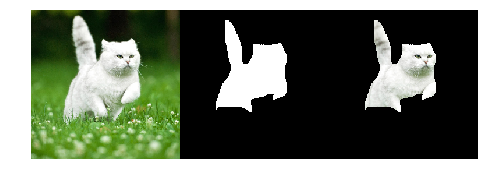

In [0]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

